In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import RandomSampler

"""Change to the data folder"""
new_path = "./new_train/new_train"
val_path = "./new_val_in/new_val_in" 
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [2]:
torch.cuda.is_available()

True

### Create a dataset class 

In [3]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)

### Check input/output distribution
#### Create Loader

In [4]:
batch_sz = 1

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = np.array([np.array(x).flatten() for x in [scene['p_in'] for scene in batch]])
    out = np.array([np.array(x).flatten() for x in [scene['p_out'] for scene in batch]])
    return [inp[0], out[0]]

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0, drop_last=True)


#### Extract values of input/output

In [ ]:
def round_down(num):
    return num - (num%100)

dct_inp = defaultdict(int)
dct_out = defaultdict(int)

for i_batch, batch in tqdm(enumerate(train_loader)):
    inp, out = batch
    inp = [x for x in inp if x != 0]
    out = [x for x in out if x != 0]
    for i in inp:
        dct_inp[(nearest_base(i) + 50)] += 1
    for o in out:
        dct_out[(nearest_base(o) + 50)] += 1

In [75]:
def round_down_500(num):
    return num - (num%500)

new_inp = defaultdict(int)
for key in dct_inp.keys():
    new_inp[round_down_500(key)] += dct_inp[key]

new_out = defaultdict(int)
for key in dct_out.keys():
    new_out[round_down_500(key)] += dct_out[key]

Text(0.5, 1.0, 'Input Positions')

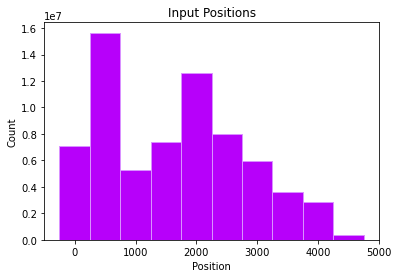

In [74]:
plt.bar(new_inp.keys(), new_inp.values(), width=500, facecolor='#b700fa', edgecolor='#d991ff')
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Input Positions')

Text(0.5, 1.0, 'Output Positions')

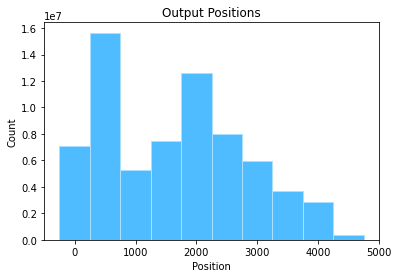

In [73]:
plt.bar(new_out.keys(), new_out.values(), width=500, facecolor='#4fbcff', edgecolor='#abdfff')
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Output Positions')

In [16]:
json.dump(dct_inp, open('inp_bins.json', 'w'))
json.dump(dct_out, open('out_bins.json', 'w'))

In [26]:
min(dct_inp.keys()) , max(dct_inp.keys()) + 50

(-50, 4800)

### Visualize the batch of sequences

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


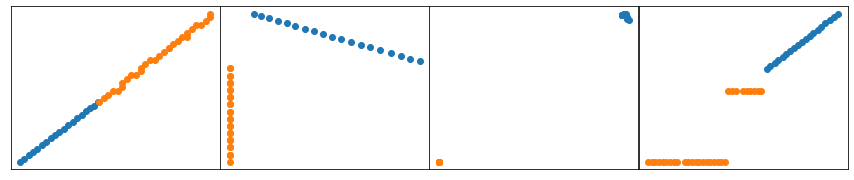

In [31]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break

In [24]:
preds.to_csv('test_preds.csv')